<a href="https://colab.research.google.com/github/hantedyou/kccnlpClass/blob/main/predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading modules

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#-----------

In [ ]:
import os, sys
from google.colab import drive

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/kcc/KCCNLP2022'       # path to your project on Drive



drive.mount(ROOT)           
PROJECT_PATH = os.path.join(ROOT, PROJ)  
print(PROJECT_PATH)
os.chdir(PROJECT_PATH)
os.listdir()[:10]

Mounted at /content/drive
/content/drive/My Drive/kcc/KCCNLP2022


['data',
 '「01_transformers_multiclass_classification.ipynb」的副本',
 '「XLNet_toxic_comment_classification_challenge_share.ipynb」的副本',
 'KCCNLP2021_DEA.ipynb',
 '「transformers_multi-label_classification.ipynb」的副本',
 'chinese_xlnet_mid_L-24_H-768_A-12',
 'xlnet_KCC_classes',
 'submission.csv',
 'Multi Class Text Classification XLNET.ipynb',
 '「rowdata_predition.ipynb」的副本']

# 隨機抽取

# 讀入資料

In [ ]:
# path_test_data = 'data/test_070401.csv'
path_test_data = 'data/data_3000.csv'

In [ ]:
df = pd.read_csv(path_test_data)
#df = data.sample(frac=1).iloc[0]
x = df['content']
y = df['reCheckedsubject']
len(x),len(y)

(3000, 3000)

# 載入模型

In [ ]:
from torch import nn

class OurModel(nn.Module):
  def __init__(self, ori_model, num_labels):
    super(OurModel, self).__init__()
    self.num_labels = num_labels

    self.model = model = ori_model
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(768, num_labels)

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    layers = self.dropout(outputs[0])
    logits = self.classifier(layers[:, 0, :].view(-1, 768))

    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)


In [ ]:
import torch
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import AutoModel, AutoTokenizer

In [ ]:
NAME = "uer/roberta-base-finetuned-jd-full-chinese"
model = OurModel(AutoModel.from_pretrained(NAME), 32)

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of the model checkpoint at uer/roberta-base-finetuned-jd-full-chinese were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 從/model 資料夾載入自己訓練的資料

In [ ]:
checkpoint = torch.load('model/roberta-base-AverageSample_15.zip', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
tokenizer = AutoTokenizer.from_pretrained(NAME)

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# 預測

## 單筆預測

In [ ]:
data_index = 5

inputs = tokenizer(x[data_index], max_length=512, return_tensors='pt')
logits = model(inputs['input_ids'], inputs['attention_mask'])

predition_Y = torch.argmax(logits.logits[0].cpu()).tolist()
print(f"實際標籤: {y[data_index]}")
print(f"預測標籤: {predition_Y}")

x[data_index]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


實際標籤: 6
預測標籤: 6


'另外，對於兒童少年保護的關切，我們市政府一定會特別的重視，我希望在下半年跟議會能做一個專案的報告。這個報告有一個好處，讓議員能瞭解、市民能瞭解，同時讓我們市政府的團隊也能夠重視，我覺得專案報告它有這幾個綜合性的好處，所以下半年我想我們針對如何保護高雄的幼兒、少年、青少年等等，尤其是各方面你剛剛講的，不管是安全、兩性平等、虐待，我想兒少這一塊於下一個會期，我們跟議會做一個專案報告，要再請郭議員建盟一起來參加，好不好？非常感謝你的質詢，非常感謝。'

# 整批預設

### **如果要隨機抽一些測試執行此欄**

In [ ]:
# 抽出來的資料會用原本的index，ignore_index會重編，下方預測的迴圈才不會中斷。
test_df = df.sample(100, ignore_index = True)
x = test_df['content']
y = test_df['classes']

# 開始整批預測

In [ ]:
# list_pred_y:存放預測結果
list_pred_y = []

# d = {'col1': [1, 2], 'col2': [3, 4]}
# df = pd.DataFrame(data=d)

In [ ]:
for i in range(len(x)):
  inputs = tokenizer(x[i], max_length=512, return_tensors='pt')
  logits = model(inputs['input_ids'], inputs['attention_mask'])
  predition_Y = torch.argmax(logits.logits[0].cpu()).tolist()
  list_pred_y.append(predition_Y)
  #print(f"實際標籤: {y[i]}")
  #print(f"預測標籤: {predition_Y}")

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_true, y_pred)
acc_score = accuracy_score(result['true_y'], result['pred_y'])
acc_score

0.93

In [ ]:
import numpy as np
acc_score = np.round(acc_score)

In [ ]:
result = pd.DataFrame({'content': x, 'pred_y':list_pred_y, 'true_y':y})
result.columns,result.head()
result.to_csv(f'result/roberta-base-TrainBy3000-Pred3000-acc{acc_score}.csv')

# ================以上是完整使用一次模型來預測===============

In [ ]:
a = BatchPredict(df.sample(50, ignore_index = True) , x_name = 'content', y_name='reCheckedsubject', partial=0.2)

In [ ]:
from sklearn.metrics import accuracy_score
def BatchPredict(df, x_name, y_name, partial=0.2):
  test_len = int(len(df)*0.2) # 每次抽樣長度
  total_len = len(df)
  acc_list = []
  for i in range(int(total_len/test_len)-1):
    print(f"Run {i},total len :{total_len},test_len:{test_len}")
    if total_len < test_len:
      test_len = total_len
      print(f"total_len < test_len, update test_len to {test_len}")
    # 從母體抽取部分資料，並將抽出的由母體中刪除
    # df['freq'] = df.groupby(y_name)[y_name].transform('count')
    test_df = df[:test_len]
    # 從母體中移除val set
    test_number = test_df['編號']
    df = df[~df['編號'].isin(test_number)]
    total_len -= test_len
    print(f"Update total len to {total_len}")

    x = test_df[x_name]
    print("index of x:{}".format(x.index))
    y = test_df[y_name]
    
    # list_pred_y:存放預測結果
    list_pred_y = []
    
    for i in range(len(test_df)):
      print('x[{}]:{}'.format(i,x[i]))
      print('y[i]:{}'.format(y[i]))
      inputs = tokenizer(x[i], max_length=512, return_tensors='pt')
      logits = model(inputs['input_ids'], inputs['attention_mask'])
      predition_Y = torch.argmax(logits.logits[0].cpu()).tolist()
      print(f'predict y :{predition_Y}')
      list_pred_y.append(predition_Y)
    
    result = pd.DataFrame({'content': x, 'pred_y':list_pred_y, 'true_y':y})
    acc_list.append(accuracy_score(result['true_y'], result['pred_y']))

    print("acc_list:{}".format(acc_list))
  return acc_list

## Trainning with Sample by Freq

In [ ]:
# list_pred_y:存放預測結果
list_pred_y = []

# d = {'col1': [1, 2], 'col2': [3, 4]}
# df = pd.DataFrame(data=d)

In [ ]:
for i in range(len(x)):
  inputs = tokenizer(x[i], max_length=512, return_tensors='pt')
  logits = model(inputs['input_ids'], inputs['attention_mask'])
  predition_Y = torch.argmax(logits.logits[0].cpu()).tolist()
  list_pred_y.append(predition_Y)
  #print(f"實際標籤: {y[i]}")
  #print(f"預測標籤: {predition_Y}")

In [ ]:
result = pd.DataFrame({'content': x, 'pred_y':list_pred_y, 'true_y':y})
result.columns,result.head()
result.to_csv('result/roberta-base-AverageSample.csv')

# 計算模型準確率

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_true, y_pred)
accuracy_score(result['true_y'], result['pred_y'])

0.988

https://medium.com/analytics-vidhya/multi-class-ml-models-evaluation-103c9fdadb41

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#labels = list(test_df['classes'].unique()) 
labels = list(y.unique())
print(classification_report(y, list_pred_y)) #classification report from sklearn
cnf_matrix = confusion_matrix(y, list_pred_y, labels=labels)


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       333
           1       0.97      1.00      0.98        91
           2       0.99      0.93      0.96       143
           3       1.00      0.91      0.95        33
           4       0.99      1.00      1.00       167
           5       1.00      0.99      0.99       334
           6       1.00      1.00      1.00        95
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        11
          10       1.00      0.98      0.99       135
          11       0.98      1.00      0.99        63
          12       0.98      1.00      0.99        48
          13       1.00      1.00      1.00        31
          14       1.00      1.00      1.00        96
          15       0.97      0.97      0.97        39
          16       1.00      0.98      0.99       129
          17       0.99    

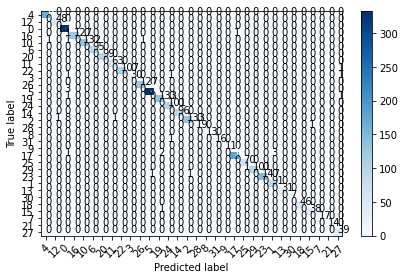

In [ ]:

plt.imshow(cnf_matrix, cmap=plt.cm.Blues, interpolation='nearest', aspect='auto') #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()